### Project Title: 
### Industry-level Impact of Environmental, Social and Governance (ESG) Factors for Alternative Investment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from surprise import SVD, accuracy,Reader, Dataset
from surprise.model_selection import train_test_split,cross_validate, GridSearchCV

### 1. Read Data
#### Read industry catagory data which has been downloaded from Bloomberg Terminal 

In [2]:
SP500_industry_df = pd.read_excel('sp500_indus_ret_vol.xlsx',sheet_name ='indus')
SP500_industry_df.columns = SP500_industry_df.iloc[0]
#SP500_industry_df = SP500_industry_df.drop([0],axis=0)
#SP500_industry_df.head()

#### We only use two industry categories: industry sector and GICS industry classification 

In [3]:
SP500_GICS_df = SP500_industry_df[['INDUSTRY_SECTOR','GICS_INDUSTRY_NAME']]
SP500_GICS_df = SP500_GICS_df.reset_index()
#SP500_GICS_df.head()

In [4]:
# esg_df = pd.read_csv('SP500_Data/AEE UN Equity.csv'.format(name),index_col = 0)
# SP500_GICS_df.groupby(['INDUSTRY_SECTOR']).head()
# for i in SP500_GICS_df.INDUSTRY_SECTOR.unique():
#     print(SP500_GICS_df[1:10])

#### Read SP500 ticker data. It contains total ESG score and Enviromental, Social, Governmance score separately

In [5]:
SP500_name = SP500_industry_df.index
total_score_colname = ['Year','ESG Disclosure Score','Environmental Disclosure Score','Social Disclosure Score','Governance Disclosure Score']
onlyESG_df = pd.DataFrame()
for name in SP500_name[1:]:
    try:
        esg_df = pd.read_csv('SP500_Data/{}.csv'.format(name),index_col = 0)
        esg_df = esg_df[total_score_colname]
        esg_df['company_name'] = name

        onlyESG_df = pd.concat([onlyESG_df,esg_df])
    except:
        pass
onlyESG_df = onlyESG_df.dropna().reset_index(drop = True)    


#### Merge two datasets based on 'company name'

In [6]:
ESG_industry_df = onlyESG_df.merge(SP500_GICS_df, left_on = 'company_name',right_on = 'index', how = 'left')
ESG_industry_df = ESG_industry_df.drop(columns = ['index'])
ESG_industry_df.head()

,Year,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Governance Disclosure Score,company_name,INDUSTRY_SECTOR,GICS_INDUSTRY_NAME
0,2010,30.5785,26.3566,19.2982,51.7857,LYB UN Equity,Basic Materials,Chemicals
1,2012,35.5372,27.9070,33.3333,55.3571,LYB UN Equity,Basic Materials,Chemicals
2,2013,35.5372,27.9070,33.3333,55.3571,LYB UN Equity,Basic Materials,Chemicals
3,2014,33.8843,24.8062,33.3333,55.3571,LYB UN Equity,Basic Materials,Chemicals
4,2015,36.3636,29.4574,33.3333,55.3571,LYB UN Equity,Basic Materials,Chemicals


### 2. Anually Data Analysis 
#### Plot Total ESG histogram for each year, we found that recent years ESG scores are increasingly high year by year

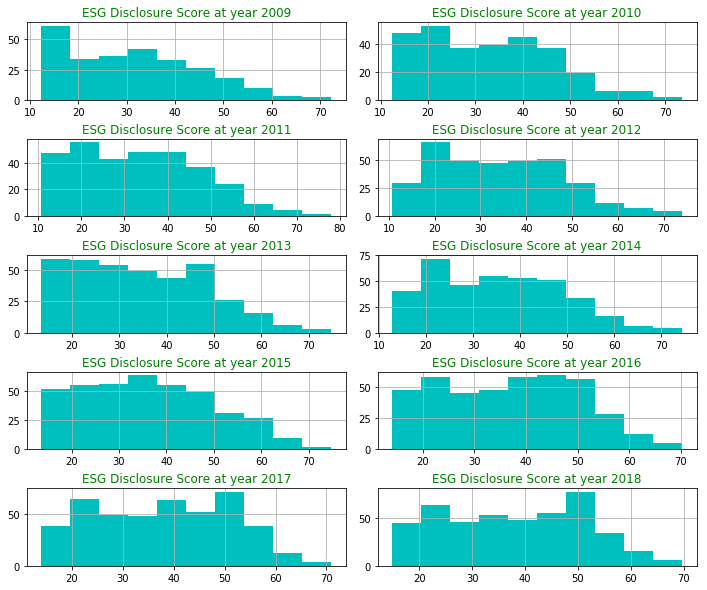

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=2,  facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()
i = 0
for year in range(2009,2019):
    #plt.figure()
    ESG_industry_df[ESG_industry_df['Year']==year]['ESG Disclosure Score'].hist(figsize = (12,10),ax =axs[i],color = 'c')
    axs[i].set_title("ESG Disclosure Score at year {}".format(year),color = 'g')
    i +=1 

In [8]:
year = 2018
ESG_eachyear  = ESG_industry_df[ESG_industry_df['Year']==year].reset_index(drop = True)

In [9]:
ESG_eachyear.head()

,Year,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Governance Disclosure Score,company_name,INDUSTRY_SECTOR,GICS_INDUSTRY_NAME
0,2018,42.9752,40.3101,33.3333,58.9286,LYB UN Equity,Basic Materials,Chemicals
1,2018,48.6842,39.2857,41.6667,75.0000,AXP UN Equity,Financial,Consumer Finance
2,2018,40.3292,21.1382,46.8750,75.0000,VZ UN Equity,Communications,Diversified Telecommunication
3,2018,21.0744,4.6512,24.5614,55.3571,AVGO UW Equity,Technology,Semiconductors & Semiconductor
4,2018,33.0579,24.8062,29.8246,55.3571,BA UN Equity,Industrial,Aerospace & Defense


### 3. Sotck Recommendation 
#### Data preprocess for recommendation algorithm 

In [10]:
def data_preprocess(data):
    ESG_industry_df  = data
    ESG_eachyear  = ESG_industry_df[ESG_industry_df['Year']==year].reset_index(drop = True)
    ESG_eachyear.index = ESG_eachyear['company_name']
    ESG_eachyear = ESG_eachyear.drop(columns=['Year','company_name'])
    ESG_eachyear =pd.concat([ESG_eachyear,pd.get_dummies(ESG_eachyear['INDUSTRY_SECTOR'])],axis = 1)
    ESG_eachyear = ESG_eachyear.drop(columns=['INDUSTRY_SECTOR','GICS_INDUSTRY_NAME'])
    ESG_eachyear -= ESG_eachyear.min()  # equivalent to df = df - df.min()
    ESG_eachyear /= ESG_eachyear.max()

    filter_matrix = pd.DataFrame(np.random.rand(448,13),index = ESG_eachyear.index, columns=ESG_eachyear.columns)
    ESG_eachyear_copy = ESG_eachyear.copy()
    ESG_eachyear[filter_matrix<0.7].isna().sum().sum()/(448*13)
    ESG_eachyear = ESG_eachyear[filter_matrix<0.7]
    ESG_industry_df[ESG_industry_df['Year']==year]
    
    return ESG_eachyear

In [12]:
def recommendation_SVD(data):
    
    reader = Reader()
    data = Dataset.load_from_df(data, reader)
    trainset, testset = train_test_split(data, test_size=0.25)
    # use the SVD algorithm here
    algo = SVD()
    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)
    
#   return accuracy.rmse(predictions)，
#   Run 5-fold cross-validation and print results
    print(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))


    param_grid = {'n_epochs': list(range(0, 100, 5)), 'lr_all': [0.002, 0.005,0.008],
                  'reg_all': [0.4, 0.6]}
    
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

    gs.fit(data)

    # best RMSE score
    print('best RMSE score:',gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
    print('parameters that gave the best RMSE score:',gs.best_params['rmse'])
    
    return None

recommendation_SVD(onlyESG_df.iloc[:,1:4])

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    29.2750 29.3745 29.6282 29.6365 28.2242 29.2277 0.5212  
MAE (testset)     24.4594 24.7448 25.0850 24.9493 23.8424 24.6162 0.4406  
Fit time          0.16    0.14    0.17    0.17    0.18    0.16    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
{'test_rmse': array([29.27500606, 29.37446867, 29.62819412, 29.63650682, 28.22418114]), 'test_mae': array([24.45943882, 24.74483887, 25.0849628 , 24.94929576, 23.84244673]), 'fit_time': (0.15752601623535156, 0.14421510696411133, 0.16626405715942383, 0.1732771396636963, 0.1752941608428955), 'test_time': (0.0037202835083007812, 0.0036139488220214844, 0.004633665084838867, 0.004021883010864258, 0.004293918609619141)}
best RMSE score: 29.23025879025049
parameters that gave the best RMSE score: {'n_epochs': 95, 'lr_all': 0.002, 'reg_all': 0.4}


### 4 Industry Ranking Plotting

In [14]:
def plot_industry_ranking_score(data, sort_name, fig_name, palette_name):
    scored_totalscore =  ESG_eachyear.groupby(['GICS_INDUSTRY_NAME']).mean().sort_values('{}'.format(sort_name), ascending=False)
    scored = scored_totalscore

    plt.figure(figsize=(8,6))

    ax = sns.barplot(y=scored.index[:15], x=scored[sort_name].head(15), data=scored, palette='{}'.format(palette_name))

    #plt.xlim(3.55, 5.25)
    plt.title('Highest Rated Top 15 Industries for ESG {} Score at Yeat 2018'.format(fig_name), weight='bold')
    plt.xlabel('{} ESG Disclosure Score'.format(fig_name), weight='bold')
    plt.ylabel('GICS Industry', weight='bold')
    plt.show()

    plt.savefig('top15_{}.png'.format(fig_name))
    return None

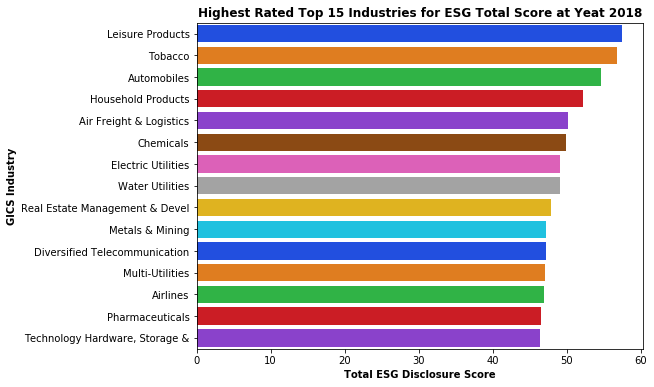

<Figure size 432x288 with 0 Axes>

In [15]:
plot_industry_ranking_score(ESG_eachyear,'ESG Disclosure Score','Total','bright')

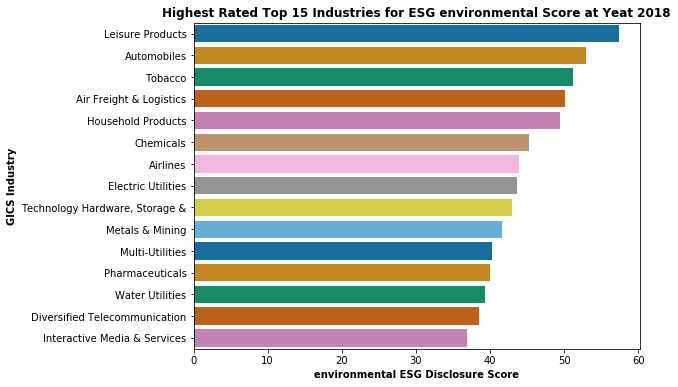

<Figure size 432x288 with 0 Axes>

In [16]:
plot_industry_ranking_score(ESG_eachyear,'Environmental Disclosure Score','environmental','colorblind')

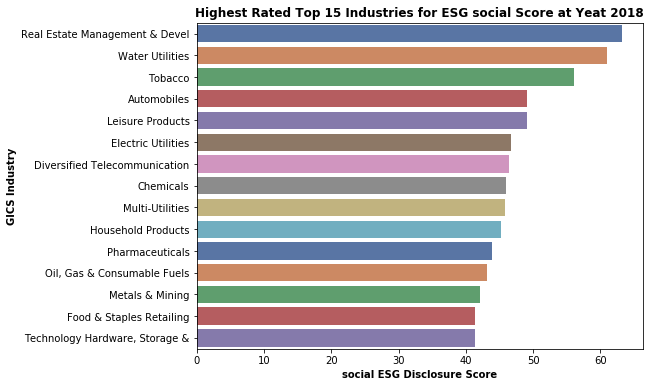

<Figure size 432x288 with 0 Axes>

In [17]:
plot_industry_ranking_score(ESG_eachyear,'Social Disclosure Score','social','deep')

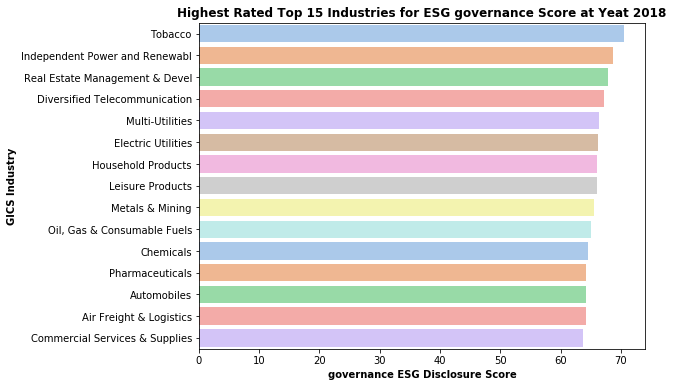

<Figure size 432x288 with 0 Axes>

In [18]:
plot_industry_ranking_score(ESG_eachyear,'Governance Disclosure Score','governance','pastel')

Generally speaking, if we consider the asset allocation at industry levels, investors
would have industry preferences for separate environmental, social or governance factors.
Investors are willing to choose more stocks following their investment logic, which means
stock recommendation based on ESG is helpful for investment decisions. In this section,
we focus on how to recommend a similar stock given a certain industry based on the
stocks we have already chosen.It provide a guidance for investors
to better take advantage of ESG investing.
